In [191]:
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()
from seaborn import pairplot
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import SGDRegressor
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.ensemble import IsolationForest,  GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import copy
from sklearn.metrics import r2_score, mean_squared_error, pairwise_distances

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
torch.set_default_device(device)

#### Useful tools to evaluate model performance

In [206]:
def model_scorer(pred_model, x_train, y_train, cv = 3):
    pred_model.fit(x_train, y_train)
    normal_score = pred_model.score(x_train, y_train)
    rand_y = y_train.sample(frac = 1)
    pred_model.fit(x_train, rand_y)
    shuffle_score = pred_model.score(x_train, rand_y)
    pred_model.fit(x_train, y_train)
    cv_score = cross_validate(pred_model, x_train, y_train, cv = cv)
    return[normal_score, shuffle_score, cv_score]

In [127]:
all_fp_data = pd.read_csv("fp_dataframe.csv")
all_data = pd.read_csv("molecules_descriptors_mordred.csv")
print(all_data.shape)
# tox_outlier = np.argmax(all_data["compound_toxicity"])
#all_data = all_data.drop(tox_outlier)
fp_data =  all_fp_data.drop(all_fp_data.columns[[0, 1, -1]], axis=1)
# fp_data = fp_data.drop(tox_outlier)
pw_dist = pairwise_distances(fp_data, n_jobs = -1)
avg_pw_dist = np.mean(pw_dist, axis=0).reshape(-1, 1)
scaler = StandardScaler()
all_data.insert(3, "avg_pw_dist", avg_pw_dist)
X_train, X_test, y_train, y_test = train_test_split(all_data.drop(all_data.columns[[0, 1, -1]], axis=1), all_data.iloc[:,-1],
                                                    test_size=0.4, random_state=2)
scaled_x_train = scaler.fit_transform(X_train)
scaled_x_test = scaler.fit_transform(X_test)

(366, 735)


c:\Users\serra\anaconda3\envs\data_analysis\Lib\site-packages\daal4py\sklearn\utils\validation.py:264: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any():


Tried some feature engineering - pairwise distances from fingerprint and add avergadge distance as feature

### Find out a bit about the data - correlation

Feature with highest (monotonic) correlation + its correlation

In [134]:
all_data_corr = all_data.drop(all_data.columns[[0,1]], axis = 1).corr(method="spearman")
my_features = all_data_corr["compound_toxicity"][np.argsort(np.abs(all_data_corr["compound_toxicity"].to_numpy()))].iloc[::-1][1:320].index.to_list()
my_features += ["compound_toxicity"]

C:\Users\serra\AppData\Local\Temp\ipykernel_15640\463231178.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  my_features = all_data_corr["compound_toxicity"][np.argsort(np.abs(all_data_corr["compound_toxicity"].to_numpy()))].iloc[::-1][1:320].index.to_list()


Reduce data to highest correlated features

In [151]:
all_data_subset = all_data[sfs_columns]
X_train, X_test, y_train, y_test = train_test_split(all_data_subset.drop(all_data_subset.columns[-1], axis=1), all_data_subset.iloc[:,-1],
                                                    test_size=0.4, random_state=2)
scaled_x_train_sub = scaler.fit_transform(X_train)
scaled_x_test_sub = scaler.fit_transform(X_test)

In [152]:
print(all_data_corr.index[np.argsort(np.abs(all_data_corr["compound_toxicity"].to_numpy()))][-2])
all_data_corr["compound_toxicity"][np.argsort(np.abs(all_data_corr["compound_toxicity"].to_numpy()))][-2]

SLogP


C:\Users\serra\AppData\Local\Temp\ipykernel_15640\1413788054.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_data_corr["compound_toxicity"][np.argsort(np.abs(all_data_corr["compound_toxicity"].to_numpy()))][-2]


0.7677753489317525

Histogram of $log(\frac{1}{LC_{50}})$\
$LC_{50}$ -> the lower the more toxic, $\frac{1}{LC_{50}}$ -> the higher the more toxic

Text(0.5, 1.0, 'Test dataset compound toxicity')

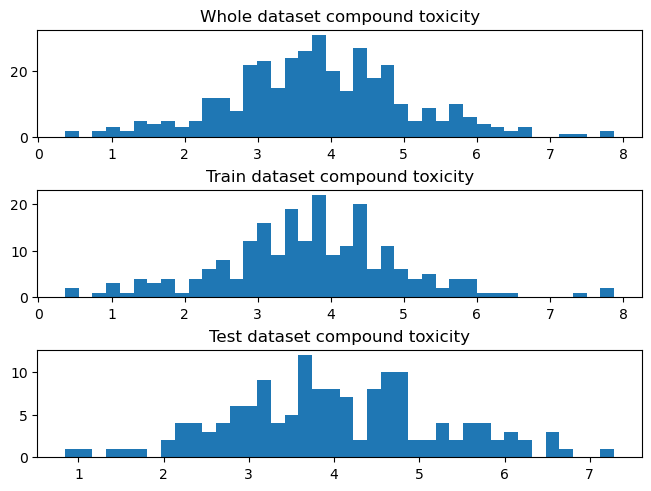

In [8]:
fig, axs = plt.subplots(3, 1, layout='constrained')#, sharex=True)
axs[0].hist(all_data["compound_toxicity"], bins = 40)
axs[1].hist(y_train, bins = 40)
axs[2].hist(y_test, bins = 40)
axs[0].set_title("Whole dataset compound toxicity")
axs[1].set_title("Train dataset compound toxicity")
axs[2].set_title("Test dataset compound toxicity")

Few super toxic compounds

#### Linear predictors

Starting with simple linear models with a shitty result (R^2)

In [87]:
sdg_regressor = SGDRegressor(max_iter=1000, tol=1e-20)
sdg_regressor.fit(scaled_x_train, y_train)
sdg_regressor.score(scaled_x_train, y_train)

-2301517.5229385532

GLMs

In [139]:
clf1 = linear_model.PoissonRegressor(max_iter=10000)
clf1.fit(scaled_x_train, y_train)
print(clf1.score(scaled_x_train, y_train))

clf2 = linear_model.TweedieRegressor()
clf2.fit(scaled_x_train, y_train)
print(clf2.score(scaled_x_train, y_train))

clf3 = linear_model.GammaRegressor()
clf3.fit(scaled_x_train, y_train)
print(clf3.score(scaled_x_train, y_train))

0.8866160260330179
0.8803738585730875
0.7997371346164366


In [140]:
clf1_pred = clf1.predict(scaled_x_train)
print(r2_score(y_train, clf1_pred))
print(mean_squared_error(y_train, clf1_pred))
print(r2_score(y_test, clf1.predict(scaled_x_test)))

0.9089988255180859
0.13929264317995832
0.5765960215392789


In [141]:
model_scorer(clf1, scaled_x_train, y_train, cv=4)

[0.8866160260330179,
 0.46849673819235305,
 {'fit_time': array([0.02400017, 0.02599788, 0.02900028, 0.03100252]),
  'score_time': array([0.00200176, 0.00099969, 0.        , 0.00099874]),
  'test_score': array([0.5892047 , 0.21513668, 0.70131328, 0.542217  ])}]

Forward feature selection with 3 x CV

In [142]:
sfs = SequentialFeatureSelector(clf1, n_features_to_select=300, direction="forward", cv = 3, n_jobs=-1,
                                scoring="r2")
sfs.fit(scaled_x_train, y_train)
clf1.fit(scaled_x_train[:,sfs.get_support()], y_train)
clf1.score(scaled_x_train[:,sfs.get_support()], y_train)

0.8429649541592358

In [150]:
sfs_columns = all_data.drop(all_data.columns[[0, 1, -1]], axis=1).columns[sfs.get_support()]

In [146]:
sfs.get_support()

array([False, False,  True, False, False,  True,  True, False, False,
        True, False, False, False,  True,  True, False, False, False,
       False, False,  True,  True,  True, False,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True, False,  True, False, False,  True, False,  True,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False, False, False, False, False, False,  True,
        True,  True,

In [263]:
model_scorer(clf1, scaled_x_train, y_train, cv=3)

[0.7603014887029105,
 0.1805352501700932,
 {'fit_time': array([0.01600099, 0.01900125, 0.01899862]),
  'score_time': array([0.        , 0.00099993, 0.        ]),
  'test_score': array([0.52313424, 0.650864  , 0.72451179])}]

In [264]:
clf1_pred = clf1.predict(scaled_x_test)
r2_score(clf1_pred, y_test)

0.4739750355457337

MultiTaskElasticNetCV

In [140]:
clf = linear_model.ElasticNetCV(cv=3, max_iter=10000)
clf.fit(scaled_x_train, y_train)
print(clf.score(scaled_x_train, y_train))

0.7159210240552529


#### Continuing with Support Vector Regression

In [97]:
svr = GridSearchCV(
    SVR(gamma=0.1),
    param_grid={"C": [1e0, 1e1, 1e2, 1e4, 1e5, 1e50], "gamma": np.logspace(-2, 1, 2, 4), "kernel":["poly", "rbf"]},
)
svr.fit(scaled_x_train, y_train)
svr.best_score_

0.6293886261845583

### Trying out NN

Training function

In [234]:
def train_nn_model(nn_model, train_data_features, train_data_res, test_data_features, test_data_res,
                   n_epochs = 20, batch_size = 5, lr = 0.0001):

    batch_start = torch.arange(0, len(X_train), batch_size)
    X_train_torch = torch.tensor(train_data_features, dtype=torch.float32)
    print(X_train_torch.device)
    y_train_torch = torch.tensor(train_data_res.to_list(), dtype=torch.float32).reshape(-1, 1)
    print(y_train_torch.device)
    X_test_torch = torch.tensor(test_data_features, dtype=torch.float32)
    print(X_test_torch.device)
    y_test_torch = torch.tensor(test_data_res.to_list(), dtype=torch.float32).reshape(-1, 1)
    print(y_test_torch.device)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(nn_model.parameters(), lr = lr)
    
    train_history = []
    test_history = []
    last_epoch = 0
    # training loop
    best_r2 = -np.inf
    for epoch in range(n_epochs):
        nn_model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train_torch[start:start+batch_size]
                y_batch = y_train_torch[start:start+batch_size]
                # forward pass
                y_pred = nn_model(X_batch)[0]
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        if epoch - last_epoch >= 100:
            print(f"Epoch: {epoch}")
            last_epoch = epoch
        nn_model.eval()
        y_pred_test = nn_model(X_test_torch)[0].reshape((-1))
        r2_test = r2_score(y_pred_test.cpu().detach().numpy(), y_test_torch.cpu().detach().numpy())
        r2_test = float(r2_test)
        test_history.append(r2_test)


        y_pred_train = nn_model(X_train_torch)[0].reshape((-1))
        r2_train = r2_score(y_pred_train.cpu().detach().numpy(), y_train_torch.cpu().detach().numpy())
        r2_train = float(r2_train)
        train_history.append(r2_train)
        if r2_test > best_r2:
            best_r2 = r2_test
            best_weights = copy.deepcopy(nn_model.state_dict())
    
    # restore nn_model and return best accuracy
    nn_model.load_state_dict(best_weights)
    return [train_history, test_history]

In [216]:
class rnn_model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(rnn_model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.fc1 = nn.Linear(input_size, int(input_size/2))
        self.fc2 = nn.Linear(int(input_size/2), int(input_size/4))
        self.act = nn.LeakyReLU()
        self.rnn = nn.RNN(int(input_size/4), hidden_dim, n_layers, batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, self.hidden_dim)
        return hidden

In [221]:
no_features = len(sfs_columns)-1

In [228]:
# Define the model
seq_model = nn.Sequential(
    nn.Linear(no_features, int(no_features/2)),
    nn.LeakyReLU(),
    nn.Linear(int(no_features/2), int(no_features/4)),
    nn.LeakyReLU(),
    nn.Linear(int(no_features/4), int(no_features/8)),
    nn.LeakyReLU(),
    nn.Linear(int(no_features/8), 1)
)
train_rnn_model = rnn_model(no_features, 1, hidden_dim=80, n_layers=2)

In [231]:
seq_train_history, seq_test_history = train_nn_model(seq_model, scaled_x_train_sub, y_train, scaled_x_test_sub, y_test, n_epochs = 200, batch_size=1)

cuda:0
cuda:0
cuda:0
cuda:0
Epoch: 100


In [235]:
rnn_train_history, rnn_test_history = train_nn_model(train_rnn_model, scaled_x_train_sub, y_train, scaled_x_test_sub, y_test, n_epochs = 200, batch_size=1)

cuda:0
cuda:0
cuda:0
cuda:0
Epoch: 100


In [232]:
print(f"Seq best test: {max(seq_test_history)}")
print(f"Seq best train: {max(seq_train_history)}")

Seq best test: 0.9406678792338976
Seq best train: 0.9988403757039341


In [ ]:
print(f"RNN best test: {max(rnn_test_history)}")
print(f"RNN best train: {max(rnn_train_history)}")

RNN best test: 0.9566778171021112
RNN best train: 0.9830813543483429


Text(0.5, 1.0, 'RNN Mode test R2')

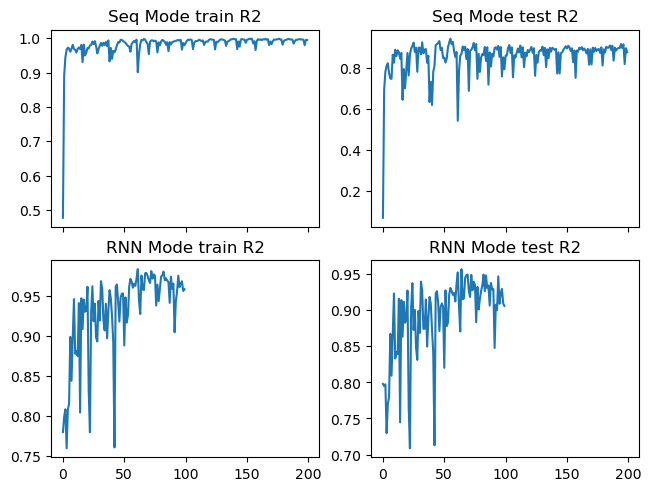

In [ ]:
fig, axs = plt.subplots(2, 2, layout='constrained', sharex=True)
axs[0,0].plot(seq_train_history)
axs[0,0].set_title("Seq Mode train R2")
axs[0,1].plot(seq_test_history)
axs[0,1].set_title("Seq Mode test R2")  
axs[1,0].plot(rnn_train_history)
axs[1,0].set_title("RNN Mode train R2")
axs[1,1].plot(rnn_test_history)
axs[1,1].set_title("RNN Mode test R2")

#### Gradient Boosting

In [47]:
params = {
    "n_estimators": [10, 100, 1000, 2000],
    "max_depth": [8,12, 20, None],
    "min_samples_split": [2,5],
    "learning_rate": [0.01, 0.001, 0.1],
    "loss": ["squared_error"],
}
reg = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8)
#reg.fit(scaled_x_train, y_train)

In [48]:
CV_gbc = GridSearchCV(estimator=reg, param_grid=params, n_jobs=-1, cv= 2)

In [49]:
CV_gbc.fit(scaled_x_train, y_train)
CV_gbc.best_params_, CV_gbc.best_score_

({'learning_rate': 0.01,
  'loss': 'squared_error',
  'max_depth': 8,
  'min_samples_split': 5,
  'n_estimators': 2000},
 0.5206883701031071)

In [39]:
reg = GradientBoostingRegressor(learning_rate=0.01, max_depth=12, min_samples_split=2, n_estimators=1000)
reg.fit(scaled_x_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=12, n_estimators=1000)

In [40]:
reg.score(scaled_x_train, y_train)

0.9999999981342598

In [41]:
reg.score(scaled_x_test, y_test)

0.45319957502284924

### GP

In [208]:
rbf_kernel = kernels.RBF(1.0, length_scale_bounds=(1e-3, 1e5))*1.0
noise_kernel = 1* kernels.WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 1e2))
periodic_kernel = kernels.ExpSineSquared(length_scale=1, periodicity=1)
full_kernel = rbf_kernel+noise_kernel*periodic_kernel
gp_rbf = GaussianProcessRegressor(kernel=full_kernel, random_state=1, alpha=0).fit(scaled_x_train_sub, y_train)

In [209]:
gp_rbf.score(scaled_x_train_sub, y_train)

0.9999642318258456

In [215]:
gp_rbf.score(scaled_x_test_sub, y_test)

0.9766690949763245

In [211]:
model_scorer(gp_rbf, scaled_x_train_sub, y_train, cv = 3)

c:\Users\serra\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\serra\anaconda3\envs\data_analysis\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__k2__noise_level is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[0.9999642318258456,
 -2.674428919213767e-06,
 {'fit_time': array([0.52708578, 0.46862006, 0.34504747]),
  'score_time': array([0.00399804, 0.00400019, 0.00500202]),
  'test_score': array([0.99575901, 0.98218278, 0.99187804])}]

In [99]:
y_mean, y_std = gp_rbf.predict(scaled_x_train_sub, return_std=True)

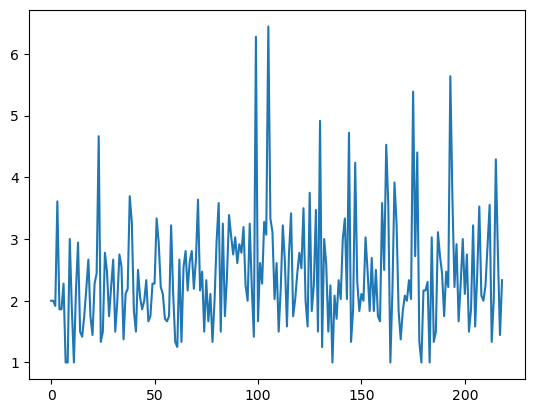

In [156]:
plt.plot(np.arange(0, y_train.shape[0]), y_train, label="Expected signal")

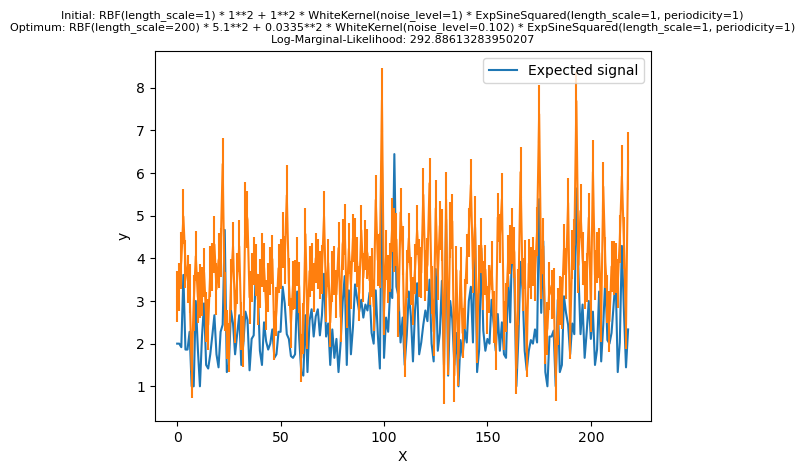

In [157]:
plt.plot(np.arange(0, y_train.shape[0]), y_train, label="Expected signal")
# plt.scatter(x=X_train[:, 0], y=y_train, color="black", alpha=0.4, label="Observations")
plt.errorbar(np.arange(0, y_train.shape[0]), y_mean, y_std)
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
_ = plt.title(
    (
        f"Initial: {full_kernel}\nOptimum: {gp_rbf.kernel_}\nLog-Marginal-Likelihood: "
        f"{gp_rbf.log_marginal_likelihood(gp_rbf.kernel_.theta)}"
    ),
    fontsize=8,
)